# Предсказание стоимости жилья

Нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году,
и предсказать медианную стоимость дома в жилом массиве.   
Для оценки качества модели используйте метрики RMSE, MAE и R2.

## Подготовка данных

In [1]:
import pandas as pd 
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor,LinearRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.feature import StandardScaler#,MinMaxScaler
from pyspark.ml.stat import Correlation

In [3]:
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("EDA California Housing") \
                    .getOrCreate()

In [5]:
# schema = StructType([
#     StructField("longitude", FloatType(), nullable=True),
#     StructField("latitude", FloatType(), nullable=True),
#     StructField("housing_median_age", FloatType(), nullable=True),
#     StructField("total_rooms", FloatType(), nullable=True),
#     StructField("total_bedrooms", FloatType(), nullable=True),
#     StructField("population", FloatType(), nullable=True),
#     StructField("households", FloatType(), nullable=True),
#     StructField("median_income", FloatType(), nullable=True),
#     StructField("median_house_value", FloatType(), nullable=True),
#     StructField("ocean_proximity", StringType(), nullable=True)]
# )

df_housing =  spark.read.csv( '/datasets/housing.csv',inferSchema=True,header=True)
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Прочитанная из датасета схема соответствует ожидаемой

Проверим незаполненные значения

In [6]:
for c in df_housing.columns:
    print(c,df_housing.select(c).count(),
          df_housing.select(c).filter(F.col(c).isNull() ).count(),
          df_housing.select(c).filter(F.col(c) ==np.nan).count(),
          df_housing.select(c).filter(F.col(c).isin([None]) ).count()
         )

longitude 20640 0 0 0
latitude 20640 0 0 0
housing_median_age 20640 0 0 0
total_rooms 20640 0 0 0
total_bedrooms 20640 207 0 0
population 20640 0 0 0
households 20640 0 0 0
median_income 20640 0 0 0
median_house_value 20640 0 0 0
ocean_proximity 20640 0 0 0


Только в одном поле (total_bedrooms) есть пустые значения , их примерно 1% .
Можно заменить их медианой,  
но количество спален сильно коррелирует с количеством комнат, поэтому ниже вместо него используется "коэффицент спален"
Поэтому пока заменим на 0 , а после расчета коэффицента поменяем на медиану

In [7]:
df_housing = df_housing.fillna(0,'total_bedrooms')
df_housing.filter(F.col('total_bedrooms').isNull()).count(),df_housing.filter(F.col('total_bedrooms')==0).count()

(0, 207)

nulls заменены на 0

Проверим полные дубликаты 

In [8]:
df_housing.groupby(df_housing.columns[2:]).count().where('count > 1').count()

0

Проверим корреляцию

In [9]:
num_cols=[
    'longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income'
]
def corr_to_df(df_rdd,cols):
    return pd.DataFrame(
        Correlation.corr(
                VectorAssembler(inputCols=cols,outputCol='v').transform(df_rdd),'v'
            ).collect()[0][0].toArray().tolist() ,
        index=cols,columns = cols 
    )    

In [10]:
corr_to_df(df_housing,num_cols).style.background_gradient(cmap='coolwarm').set_precision(2)

24/02/08 15:33:59 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/02/08 15:33:59 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
longitude,1.00,-0.92,-0.11,0.04,0.07,0.10,0.06,-0.02
latitude,-0.92,1.00,0.01,-0.04,-0.07,-0.11,-0.07,-0.08
housing_median_age,-0.11,0.01,1.00,-0.36,-0.32,-0.30,-0.30,-0.12
total_rooms,0.04,-0.04,-0.36,1.00,0.92,0.86,0.92,0.20
total_bedrooms,0.07,-0.07,-0.32,0.92,1.00,0.87,0.97,-0.01
population,0.10,-0.11,-0.30,0.86,0.87,1.00,0.91,0.00
households,0.06,-0.07,-0.30,0.92,0.97,0.91,1.00,0.01
median_income,-0.02,-0.08,-0.12,0.20,-0.01,0.00,0.01,1.00


Есть несколько колонок , сильно коррелирующих с количеством домов в районе.    
В курсе была идея заменить их на коэффициенты относительно количества домов, что уменьшит прямую корреляцию признаков, но всё же сохранит полезную информацию о плотности населения и количестве комнат на дом, которая может влиять на цену  

Кроме того сильно коррелируют географические координаты, видимо это связано с тем , что Калифорния вытянута c NW на SE.  
Можно повернуть координаты так, чтобы длинная ось была вдоль побережья, а вторая поперек, в этом случае вторая ось будет коррелировать с расстоянием от океана.  
Точный угол поворота можно рассчитать из набора данных (но этом случае он будет зависеть от набора и его надо пересчитывать при предсказании). Я думаю, что достаточно повернуть на 45град, заменив координаты разностью и суммой - это грубое улучшение, но все же лучше, чем исходный набор 

In [11]:
df_housing = df_housing.withColumn('k_rooms', F.col('total_rooms')/F.col('households') )
df_housing = df_housing.withColumn('k_population', F.col('population')/F.col('households') )
df_housing = df_housing.withColumn('k_bedrooms', F.col('total_bedrooms')/F.col('total_rooms') )
df_housing = df_housing.withColumn('sum_xy', F.col('longitude')+F.col('latitude') )
df_housing = df_housing.withColumn('diff_xy', F.col('longitude')-F.col('latitude') )

In [12]:
new_num_cols = [
   'sum_xy','diff_xy','housing_median_age','k_rooms','k_bedrooms','k_population' ,'households','median_income'
]
corr_to_df(df_housing,new_num_cols).style.background_gradient(cmap='coolwarm').set_precision(2)

,sum_xy,diff_xy,housing_median_age,k_rooms,k_bedrooms,k_population,households,median_income
sum_xy,1.00,-0.17,-0.24,0.21,-0.06,0.01,-0.05,-0.25
diff_xy,-0.17,1.00,-0.06,-0.07,0.10,-0.00,0.06,0.03
housing_median_age,-0.24,-0.06,1.00,-0.15,0.13,0.01,-0.30,-0.12
k_rooms,0.21,-0.07,-0.15,1.00,-0.39,-0.00,-0.08,0.33
k_bedrooms,-0.06,0.10,0.13,-0.39,1.00,0.00,0.06,-0.57
k_population,0.01,-0.00,0.01,-0.00,0.00,1.00,-0.03,0.02
households,-0.05,0.06,-0.30,-0.08,0.06,-0.03,1.00,0.01
median_income,-0.25,0.03,-0.12,0.33,-0.57,0.02,0.01,1.00


В набор трансформированных колонок корреляции гораздо меньше и сильных корреляци нет совсем

Здесь можно поправить записи с нулем спален - заменяем нулевой коэффицент на медиану и считаем комнаты 

In [13]:
med_bedrooms = df_housing.approxQuantile('k_bedrooms', [0.5], 0)[0]

df_housing=df_housing.withColumn('k_bedrooms',F.when(df_housing.k_bedrooms==0,.2).otherwise(df_housing.k_bedrooms))
df_housing=df_housing.withColumn('total_bedrooms',
        F.when(df_housing.total_bedrooms==0, df_housing.k_bedrooms*df_housing.total_rooms). \
          otherwise(df_housing.total_bedrooms)
        )                         
                                 

Наконец , категориальная колонка ocean_proximity видимо монотонна по цене(хотя и нелинейна) и в принципе может быть закодирована числами по возрастанию, так что применение линейной регрессии к ней будет корректно.

In [14]:
dc = {'ISLAND':4,'NEAR BAY':3,'NEAR OCEAN':2,'<1H OCEAN':1,'INLAND':0}
map_col = F.create_map([F.lit(x) for i in dc.items() for x in i])
df_housing=df_housing.withColumn('i_proxy', map_col[F.col('ocean_proximity')])
num_cols_with_proxy = num_cols + ['i_proxy']
num_cols_with_target = new_num_cols+['i_proxy','median_house_value']
corr_to_df(df_housing,num_cols_with_target).style.background_gradient(cmap='coolwarm').set_precision(2)

,sum_xy,diff_xy,housing_median_age,k_rooms,k_bedrooms,k_population,households,median_income,i_proxy,median_house_value
sum_xy,1.00,-0.17,-0.24,0.21,-0.07,0.01,-0.05,-0.25,-0.65,-0.49
diff_xy,-0.17,1.00,-0.06,-0.07,0.10,-0.00,0.06,0.03,-0.14,0.05
housing_median_age,-0.24,-0.06,1.00,-0.15,0.14,0.01,-0.30,-0.12,0.30,0.11
k_rooms,0.21,-0.07,-0.15,1.00,-0.42,-0.00,-0.08,0.33,-0.11,0.15
k_bedrooms,-0.07,0.10,0.14,-0.42,1.00,0.00,0.06,-0.61,0.07,-0.25
k_population,0.01,-0.00,0.01,-0.00,0.00,1.00,-0.03,0.02,-0.02,-0.02
households,-0.05,0.06,-0.30,-0.08,0.06,-0.03,1.00,0.01,0.01,0.07
median_income,-0.25,0.03,-0.12,0.33,-0.61,0.02,0.01,1.00,0.16,0.69
i_proxy,-0.65,-0.14,0.30,-0.11,0.07,-0.02,0.01,0.16,1.00,0.40
median_house_value,-0.49,0.05,0.11,0.15,-0.25,-0.02,0.07,0.69,0.40,1.00


Я вывел карту корреляции для модифицированных колонок и цены.  
Видимо, на цену наиболее сильно влияют средний доход в районе  и близость к океану.  
(Также можно отметить корреляцию между i_proxy и суммой координат - положением по оси SW-NE - обе показывают расстояние от океана)    
Неожиданно цена умеренно антикоррелирует с количеством спален.  
Влияние остальных признаков видимо невелико.

Все подготовительные преобразования не использовали аггрегированные свойства датасетов и основывались только на переменных из одной записи. 
Поэтому их корректно применить ко всем тестовым и обучающим наборам до их разделения и начала обучения.

## Обучение моделей

Создадим две пары обучающих/тестовых датасетов - для теста трансформаций признаков и для финального теста

In [15]:
(trfi,te ) = df_housing.randomSplit([0.75, 0.25],seed=499)
(tr,  va ) = trfi.randomSplit([0.75, 0.25],seed=4999)

Класс для прогона датасетов через пайплайн.  
В двух вариантах - c OHE трансформацией и без неё на числовых признаках, различаются только построением пайплайна
После каждого прогона вычисляются метрики и запсываются в атрибут rm

In [16]:
class ExecPlan:
    def __init__(self,name,num_cols):
        self.name = name
        self._id = ''.join([c for c in name if c.isupper()])
        self.num_cols = num_cols
        self.stages = []
        self.ta_col = 'median_house_value'
        self.cat_col = 'ocean_proximity'
        
    def create_pipe(self): 
        self.pipe = Pipeline(stages = self.stages)

        
class NumOnlyPlan(ExecPlan):
        
    def create_pipe(self):
        self.stages.append( VectorAssembler( inputCols = self.num_cols ,outputCol='va_'+self._id))
        self.stages.append( StandardScaler( inputCol = 'va_'+self._id ,outputCol='fe_'+self._id, withMean=True))
        self.stages.append( LinearRegression(featuresCol='fe_'+self._id, 
                                             labelCol=self.ta_col,
                                             predictionCol='pr_'+self._id))
        super().create_pipe()
           
    
class OhePlan(ExecPlan):    
        
    def create_pipe(self):
        self.stages.append(StringIndexer(inputCol=self.cat_col ,outputCol='si_'+self._id,handleInvalid='keep'))
        self.stages.append(OneHotEncoder(inputCol='si_'+self._id ,outputCol='ohe_'+self._id))                   
        self.stages.append(VectorAssembler(inputCols=self.num_cols+['ohe_'+self._id] ,outputCol='va_'+self._id))
        self.stages.append( StandardScaler( inputCol = 'va_'+self._id ,outputCol='fe_'+self._id, withMean=True))
        self.stages.append( LinearRegression(featuresCol='fe_'+self._id, 
                                             labelCol=self.ta_col,
                                             predictionCol='pr_'+self._id))
        super().create_pipe()
    
 

Проверим на тестовом наборе элементарные трансформации (по 1-2 колонки) - что мы от них приобретаем и теряем.   
Первая конфигурация - исходные числовые колонки без OHE рассматривается как эталон, с ней будем сравнивать остальные.

In [17]:
plans= (NumOnlyPlan(name='Original num columns ____',num_cols=num_cols),
        NumOnlyPlan(name='geo XY rotated___________',num_cols=['sum_xy','diff_xy']+num_cols[2:]),
        NumOnlyPlan(name='Population transformed___',num_cols=['k_population' if x=='population'else x for x in num_cols]), 
        NumOnlyPlan(name='Rooms&Bedrooms transformed',num_cols=num_cols[:3]+['k_rooms','k_bedrooms']+num_cols[5:]), 
        NumOnlyPlan(name='Ocean_Proxy as Ordinal ___', num_cols=num_cols+['i_proxy']),
        OhePlan( name =  'OHE transformation _______' ,num_cols=num_cols)
       ) 


for p in plans:
    p.create_pipe()
    p.pipe= p.pipe.fit(tr)
    va= p.pipe.transform(va)
    pred_col = 'pr_'+p._id
    p.rm= RegressionMetrics( va.rdd.map(lambda r: ( r[pred_col],r.median_house_value ) ) )

24/02/08 15:34:06 WARN Instrumentation: [dd554ae9] regParam is zero, which might cause numerical instability and overfitting.
24/02/08 15:34:07 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/02/08 15:34:07 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
24/02/08 15:34:12 WARN Instrumentation: [893ed4f5] regParam is zero, which might cause numerical instability and overfitting.
24/02/08 15:34:17 WARN Instrumentation: [cab5f7e9] regParam is zero, which might cause numerical instability and overfitting.
24/02/08 15:34:22 WARN Instrumentation: [3621f0b7] regParam is zero, which might cause numerical instability and overfitting.
24/02/08 15:34:26 WARN Instrumentation: [f81cf24c] regParam is zero, which might cause numerical instability and overfitting.
24/02/08 15:34:32 WARN Instrumentation: [928616c5] regParam is zero, which might cause numerical instability and overfitting.
24/02/08 15:34:33 WARN In

## Анализ результатов

In [18]:
for p in plans:
    p.out = f"{p.name}\t{round(p.rm.r2,4)}\t{round(p.rm.rootMeanSquaredError)}\t{round(p.rm.meanAbsoluteError)}"


Выведем результат в виде таблицы

In [19]:
print(f"____Тип трансформации____\t __R2__\t_RMSE_\t_MAE_")
for p in plans:
    print(p.out)

____Тип трансформации____	 __R2__	_RMSE_	_MAE_
Original num columns ____	0.642	70608	52084
geo XY rotated___________	0.642	70608	52084
Population transformed___	0.6168	73044	54087
Rooms&Bedrooms transformed	0.6519	69618	51172
Ocean_Proxy as Ordinal ___	0.6433	70480	51810
OHE transformation _______	0.6499	69823	50982


Но может быть более наглядно будет графически:

In [20]:
res=pd.DataFrame(list(map(lambda e:[e.name,e.rm.r2 ],plans)),columns=['name','R2']).sort_values(by='R2').set_index('name')

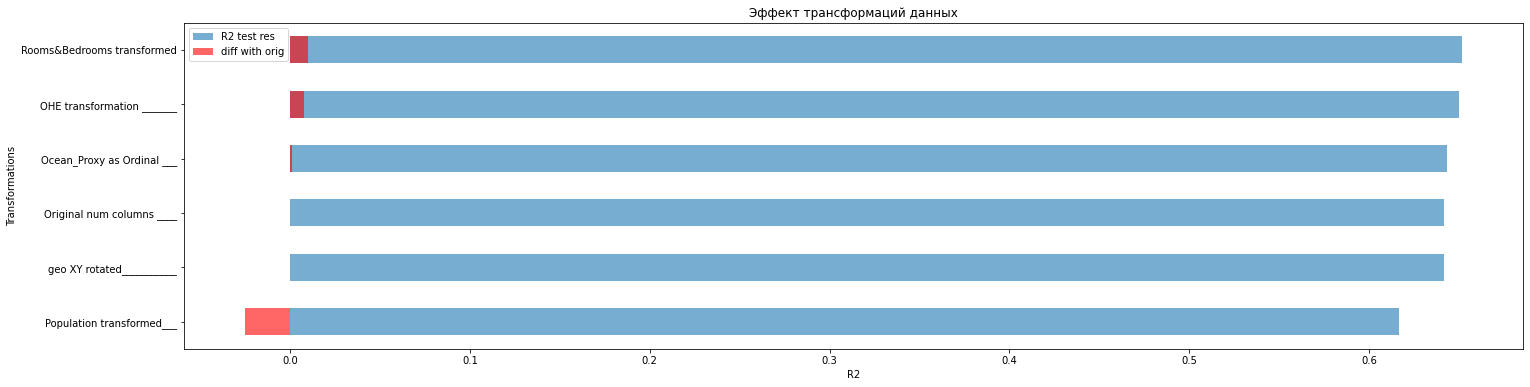

In [21]:
def plot_datasets_diff(df,base,title='Эффект трансформаций данных'):
    ax = df.plot.barh(alpha=.6,figsize=(24,6),title=title)
    ax.barh(df.index,df.R2-base ,color='r',height = 0.5 ,alpha=.6,label='diff with orig')
    ax.set_xlabel('R2')
    ax.set_ylabel('Transformations')
    ax.legend(['R2 test res','diff with orig'])
plot_datasets_diff(res,res.loc['Original num columns ____','R2'])    

* OHE категориальной колонки улучшает метрики
* Порядковое кодирование  категориальной колонки также улучшает метрики, но гораздо слабее
* Также улучшает метрики  переход к коэффициентам на дом для количества комнат и спален
* Переход о населения района к заселенности дома неожиданно ухудшает метрику

Последний пункт я объяснить не могу, возможно зависимость цены от заселенности сильно нелинейна


## ФИНАЛЬНЫЙ ТЕСТ

Для финального теста взяты признаки из трансформировнного набора колонок , кроме k_population, так он по непонятной причине портит метрику  

Так же не используется порядковое пробразование ocean_proximity -> i_proxy, так как я ожидаю, что его полезный эффект все равно будет перекрыт OHE.

In [22]:
fin = OhePlan(name='Final test' ,
    num_cols=['sum_xy','diff_xy','housing_median_age','k_rooms','k_bedrooms','population','households','median_income'])
fin.create_pipe()
fin.pipe= fin.pipe.fit(trfi)
te= fin.pipe.transform(te)
pred_col = 'pr_'+fin._id
fin.rm= RegressionMetrics( te.rdd.map(lambda r: ( r[pred_col],r.median_house_value ) ) )

24/02/08 15:34:46 WARN Instrumentation: [fc3b35f2] regParam is zero, which might cause numerical instability and overfitting.
24/02/08 15:34:47 WARN Instrumentation: [fc3b35f2] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Метрики теста

In [23]:
print( "R2 ____", round(fin.rm.r2,4))
print( "RMSE __", round(fin.rm.rootMeanSquaredError,0))
print( "MAE ___", round(fin.rm.meanAbsoluteError,0))

R2 ____ 0.6491
RMSE __ 67349.0
MAE ___ 48776.0


Основная метрика равна 0.6491 и улучшилась на 0.0018 по сравнению с версией 1.0

In [24]:
spark.stop()

## Выводы

* Построенная модель позволяет предсказывать медианную цену дома в районе с метрикой R2=0.649
* На цену дома влияет средний доход в районе, близость к океану и в меньшей степени - отношение колчества спален ко всем комнатам